In [1]:
import os
import sys

import numpy as np

from PIL import Image
sys.modules['Image'] = Image

import matplotlib.pyplot as plt

import keras
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers


Using TensorFlow backend.


Official notebook: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb

In [2]:
conv_base = VGG16(weights = 'imagenet',
                  include_top = False, #import only CNN part, without final flattened and softmax layers
                  input_shape = (150, 150, 3)) #like in previous notebook. 150x150 - just because we want so                 
                  

In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [4]:
# # Main directory in Windows (work)
# base_dir = r'C:\Users\Grigoriy\Desktop\Datasets\dogs-vs-cats_small'

In [4]:
# Main directory in Windows (home)
base_dir = r'H:\Datasets\dogs-vs-cats_small'

In [5]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

At this point, there are two ways we could proceed:

* Running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a standalone densely-connected classifier similar to those you have seen in the first chapters of this book. This solution is very fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. However, for the exact same reason, this technique would not allow us to leverage data augmentation at all.
* Extending the model we have (conv_base) by adding Dense layers on top, and running the whole thing end-to-end on the input data. This allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. However, for this same reason, this technique is far more expensive than the first one.

**Fast way feature extraction (only features from VGG16 + Dense layers)**

In [6]:
datagen = ImageDataGenerator(rescale = 1./255)
batch_size = 20

In [7]:
def extract_features(directory, sample_count):
    features = np.zeros(shape = (sample_count, 4, 4, 512))
    labels = np.zeros(shape = (sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size = (150, 150),
        batch_size = batch_size,
        class_mode = 'binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

In [8]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
print(train_features.shape)
print(validation_features.shape)
print(test_features.shape)

(2000, 4, 4, 512)
(1000, 4, 4, 512)
(1000, 4, 4, 512)


We will use densely-connected classifier, so we have to flatten our feature matrices

In [11]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [16]:
model = models.Sequential()
model.add(layers.Dense(256, activation = 'relu', input_dim = 4 * 4* 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = optimizers.RMSprop(lr = 2e-5),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

history = model.fit(train_features, train_labels,
                    epochs = 30,
                    batch_size = 2,
                    validation_data = (validation_features, validation_labels))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 18s 9ms/step - loss: 0.4984 - acc: 0.7460 - val_loss: 0.3323 - val_acc: 0.8670
Epoch 2/30
2000/2000 [==============================] - 18s 9ms/step - loss: 0.3351 - acc: 0.8465 - val_loss: 0.2808 - val_acc: 0.8920
Epoch 3/30
2000/2000 [==============================] - 17s 9ms/step - loss: 0.2797 - acc: 0.8775 - val_loss: 0.2659 - val_acc: 0.8920
Epoch 4/30
2000/2000 [==============================] - 18s 9ms/step - loss: 0.2594 - acc: 0.8955 - val_loss: 0.2587 - val_acc: 0.8980
Epoch 5/30
2000/2000 [==============================] - 18s 9ms/step - loss: 0.2440 - acc: 0.9005 - val_loss: 0.2534 - val_acc: 0.9000
Epoch 6/30
2000/2000 [==============================] - 17s 9ms/ste

In [17]:
model.save('cats_vs_dogs_simple_feature_extraction_VGG16.h5')

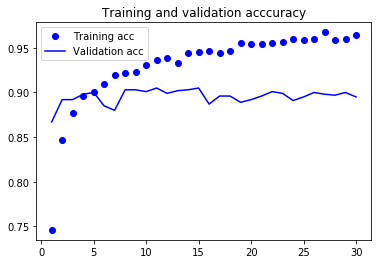

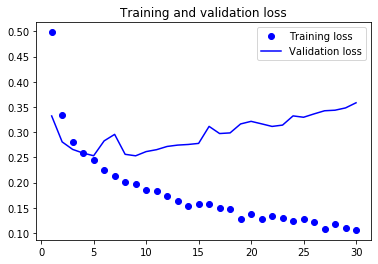

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs  = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation acccuracy')
plt.legend()

plt.show()
plt.clf()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**CNN with freezed convolutional layers of VGG16 (frozen VGG 16 CN layers + Dense layers)**

In [6]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [23]:
#freez VGG16 layers
conv_base.trainable = False

In [8]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

test_datagen = ImageDataGenerator(
    rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary')# Since we use binary_crossentropy loss, we need binary labels

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs = 30,
    validation_data = validation_generator,
    validation_steps = 50,
    verbose = 2)

In [29]:
model.save('cats_vs_dogs_frozen_VGG16.h5')

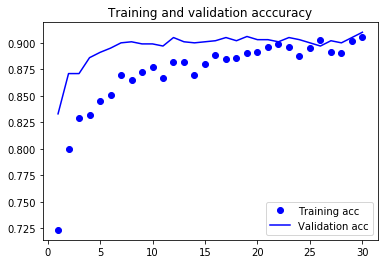

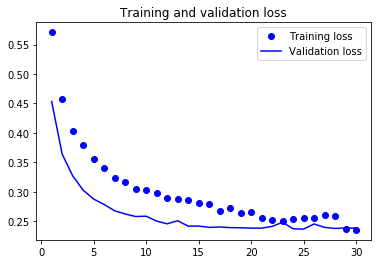

In [30]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs  = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation acccuracy')
plt.legend()

plt.show()
plt.clf()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Fine-tuning (partly frozen CN VGG 16 + Dense layers)**

We can froze only part of VGG16`s convolutions layers  

In [31]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [9]:
# Froze everything above block5
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        

In [10]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [11]:
model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(lr = 1e-5),
              metrics = ['acc'])
history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs = 100,
    validation_data = validation_generator,
    validation_steps = 50)            

Epoch 1/100
100/100 [==============================] - 98s 983ms/step - loss: 0.5037 - acc: 0.7615 - val_loss: 0.3118 - val_acc: 0.8730
Epoch 2/100
100/100 [==============================] - 90s 905ms/step - loss: 0.3319 - acc: 0.8555 - val_loss: 0.2452 - val_acc: 0.9020
Epoch 3/100
100/100 [==============================] - 90s 905ms/step - loss: 0.2754 - acc: 0.8795 - val_loss: 0.2248 - val_acc: 0.9090
Epoch 4/100
100/100 [==============================] - 90s 904ms/step - loss: 0.2602 - acc: 0.8955 - val_loss: 0.2607 - val_acc: 0.8960
Epoch 5/100
100/100 [==============================] - 90s 904ms/step - loss: 0.2358 - acc: 0.9040 - val_loss: 0.2027 - val_acc: 0.9160
Epoch 6/100
100/100 [==============================] - 92s 915ms/step - loss: 0.2200 - acc: 0.9090 - val_loss: 0.2099 - val_acc: 0.9110
Epoch 7/100
100/100 [==============================] - 95s 953ms/step - loss: 0.2139 - acc: 0.9190 - val_loss: 0.1928 - val_acc: 0.9170
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 92s 918ms/step - loss: 0.0202 - acc: 0.9925 - val_loss: 0.2279 - val_acc: 0.9330
Epoch 62/100
100/100 [==============================] - 94s 936ms/step - loss: 0.0166 - acc: 0.9950 - val_loss: 0.2359 - val_acc: 0.9340
Epoch 63/100
100/100 [==============================] - 91s 909ms/step - loss: 0.0214 - acc: 0.9920 - val_loss: 0.2439 - val_acc: 0.9370
Epoch 64/100
100/100 [==============================] - 91s 907ms/step - loss: 0.0228 - acc: 0.9915 - val_loss: 0.3557 - val_acc: 0.9180
Epoch 65/100
100/100 [==============================] - 93s 926ms/step - loss: 0.0177 - acc: 0.9945 - val_loss: 0.3184 - val_acc: 0.9270
Epoch 66/100
100/100 [==============================] - 91s 913ms/step - loss: 0.0237 - acc: 0.9910 - val_loss: 0.3426 - val_acc: 0.9250
Epoch 67/100
100/100 [==============================] - 91s 905ms/step - loss: 0.0194 - acc: 0.9930 - val_loss: 0.2356 - val_acc: 0.9320
Epoch 68/100
100/100 [===================

In [12]:
model.save('cats_vs_dogs_partly_frozen_VGG16.h5')

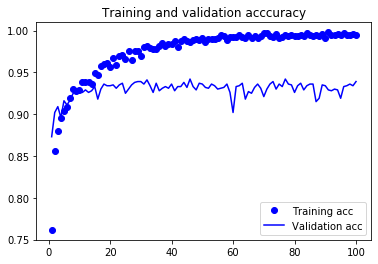

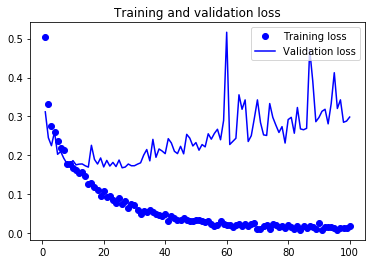

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs  = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation acccuracy')
plt.legend()

plt.show()
plt.clf()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
def smooth_curve(points, factor = 0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

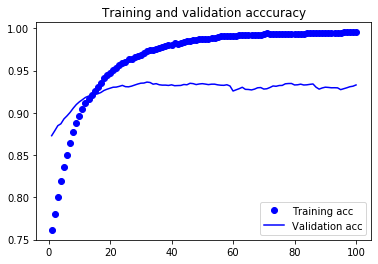

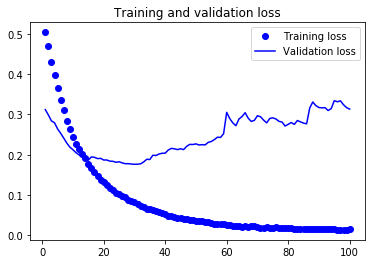

In [15]:
plt.plot(epochs, smooth_curve(acc), 'bo', label = 'Training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label = 'Validation acc')
plt.title('Training and validation acccuracy')
plt.legend()

plt.show()
plt.clf()

plt.plot(epochs, smooth_curve(loss), 'bo', label = 'Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary')
test_loss, test_acc = model.evaluate_generator(test_generator, steps = 50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9379999947547912
